<a href="https://colab.research.google.com/github/MUbarak123-56/qiskit-work/blob/master/qml/qml_wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q qiskit
!pip install -q pylatexenc
#!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
!pip install -q qiskit-aer
!pip install -q qiskit-machine-learning

In [2]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import qiskit
from sklearn.metrics import classification_report

In [3]:
wine = load_wine()

In [4]:
features = wine.data
target = wine.target

In [5]:
wine.feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [6]:
wine.target_names


array(['class_0', 'class_1', 'class_2'], dtype='<U7')

In [7]:
target[0]

0

In [8]:
wine_df = pd.DataFrame(features, columns=wine.feature_names)
wine_df["label"] = target

In [9]:
train, test = train_test_split(wine_df, test_size=0.2, random_state=42)

In [10]:
min_max = MinMaxScaler()

In [11]:
train_scaled = min_max.fit_transform(train[wine.feature_names])

In [12]:
min_max.fit(train[wine.feature_names])
test_scaled = min_max.transform(test[wine.feature_names])

In [13]:
x_train = train_scaled
x_test = test_scaled
y_train = train["label"]
y_test = test["label"]

In [14]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [15]:
x_train.shape[1]

13

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.8)

In [17]:
x_train_new = pca.fit_transform(x_train)
pca.fit(x_train)
x_test_new = pca.transform(x_test)


In [18]:
x_test_new.shape[1]

5

### Regular SVC

In [19]:
from sklearn.svm import SVC
import time
svc = SVC()
svc.fit(x_train_new, y_train)
start = time.time()
svc.fit(x_train_new, y_train)
elapsed = time.time() - start
print("Time elapsed:", elapsed)

Time elapsed: 0.002811431884765625


In [20]:
print("Training score:", svc.score(x_train_new, y_train))
print("Testing score:", svc.score(x_test_new, y_test))

Training score: 0.9929577464788732
Testing score: 1.0


### Variational Quantum Classifier

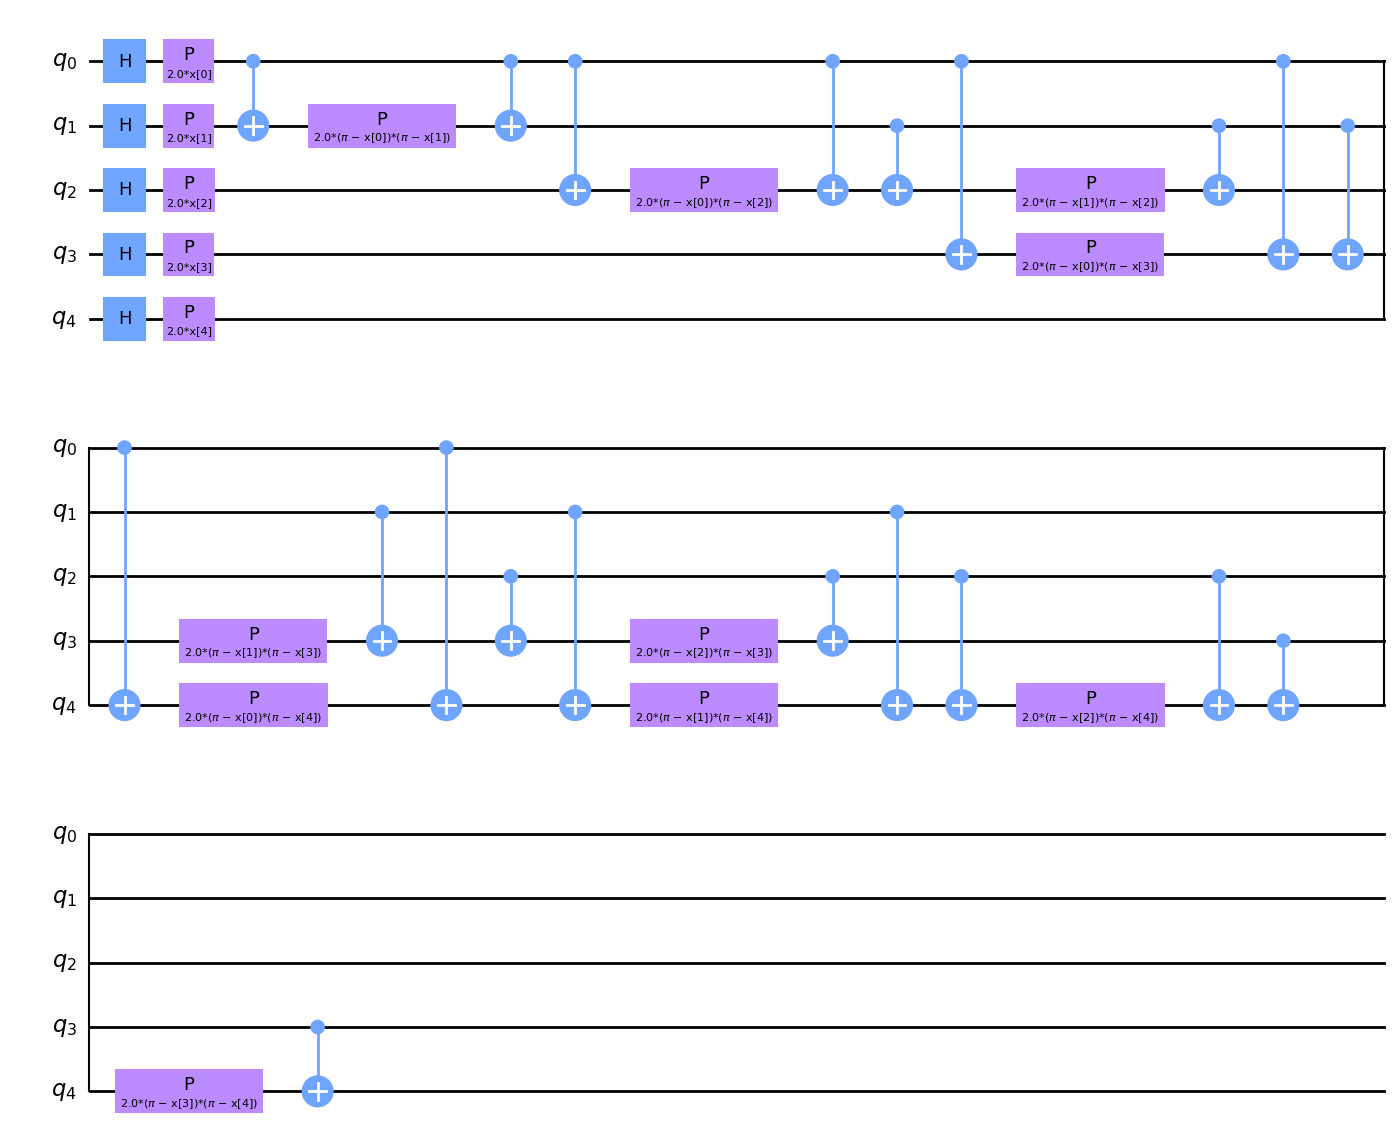

In [21]:
from qiskit.circuit.library import ZZFeatureMap

num_features = x_train_new.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

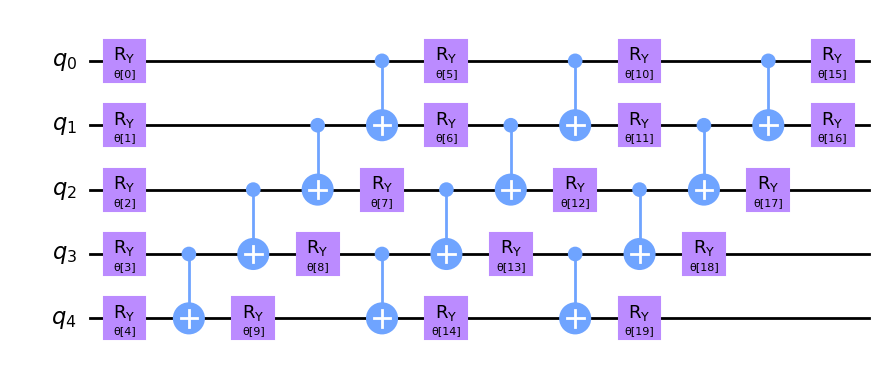

In [22]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit.library import EfficientSU2

ansatz = RealAmplitudes(num_qubits=x_train_new.shape[1], reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

In [23]:
ansatz_su = EfficientSU2(num_qubits=num_features, reps=5)

In [24]:
from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=200)

<ipython-input-24-376246a2c867>:1: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA


In [25]:
from qiskit.primitives import Sampler

sampler = Sampler()

In [26]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [27]:
x_train_new.shape

(142, 5)

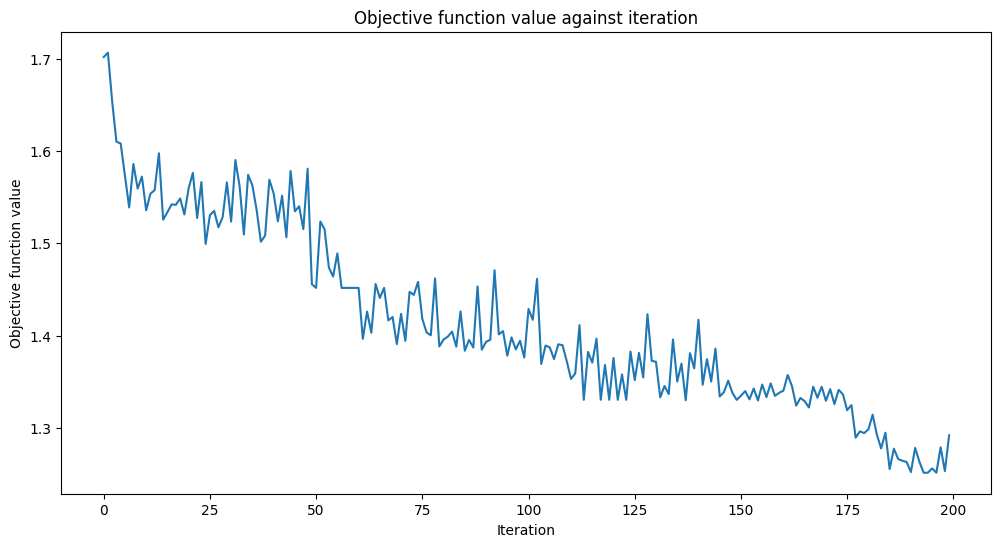

Training time: 724 seconds


In [28]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz_su,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
#objective_func_vals = []

start = time.time()
vqc.fit(x_train_new, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [29]:
train_score_q4 = vqc.score(x_train_new, y_train)
test_score_q4 = vqc.score(x_test_new, y_test)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.72
Quantum VQC on the test dataset:     0.72


### Quantum Support Vector Machine

In [30]:
import numpy as np

def data_map_eq12(x: np.ndarray) -> float:
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: np.pi*(m * n), np.cos(x))
    return coeff

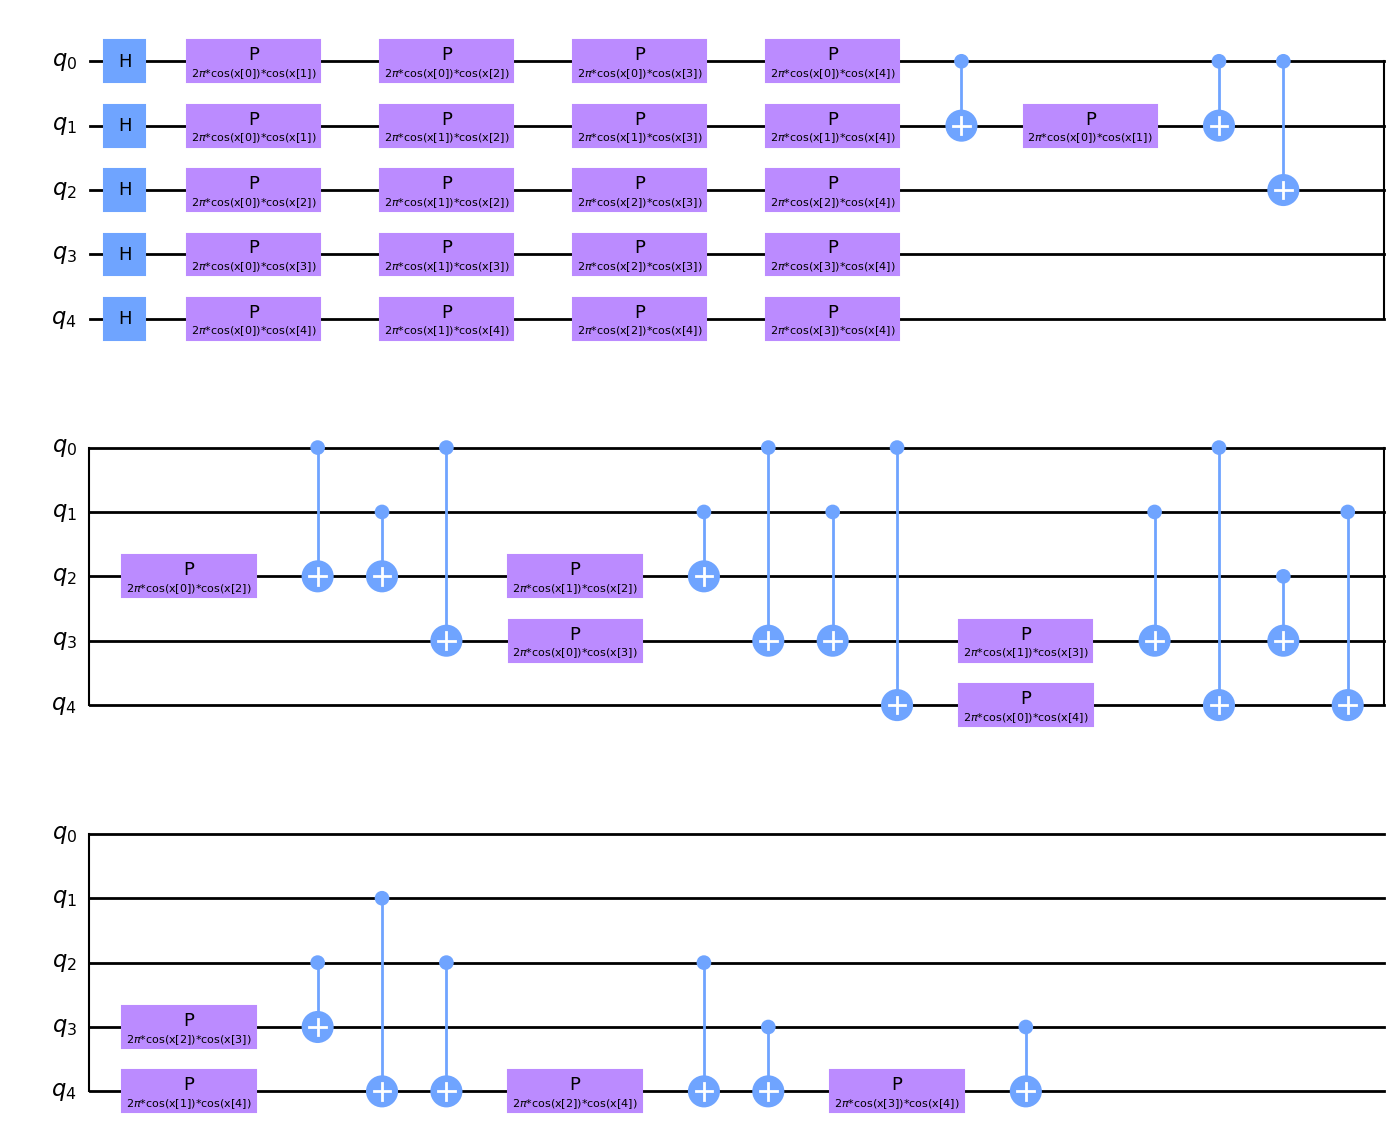

In [31]:
from qiskit.circuit.library import PauliFeatureMap
from functools import reduce

num_features = x_train_new.shape[1]

feature_map = PauliFeatureMap(feature_dimension=num_features,
                              paulis = ['ZI','IZ','ZZ'],
                              reps=1,
                              entanglement='full',
                              data_map_func=data_map_eq12)
feature_map.decompose().draw(output="mpl", fold=20)

In [32]:
from qiskit import Aer
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

import time
from qiskit_machine_learning.algorithms.classifiers import QSVC

fidelity = ComputeUncompute(sampler=sampler)
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

In [33]:

'''fidelity = ComputeUncompute(sampler=sampler)
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
matrix_train = kernel.evaluate(x_vec=x_train_new)
matrix_test = kernel.evaluate(x_vec=x_test_new, y_vec=x_train_new)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(
    np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Testing kernel matrix")
plt.show()'''

'fidelity = ComputeUncompute(sampler=sampler)\nkernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)\nmatrix_train = kernel.evaluate(x_vec=x_train_new)\nmatrix_test = kernel.evaluate(x_vec=x_test_new, y_vec=x_train_new)\n\nfig, axs = plt.subplots(1, 2, figsize=(10, 5))\naxs[0].imshow(\n    np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="Blues"\n)\naxs[0].set_title("Training kernel matrix")\naxs[1].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="Reds")\naxs[1].set_title("Testing kernel matrix")\nplt.show()'

In [34]:
# Initialize QSVC algorithm
qsvc = QSVC(quantum_kernel=kernel)

# clear objective value history
objective_func_vals = []

start = time.time()
qsvc.fit(x_train_new, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

Training time: 185 seconds


In [35]:
train_score_q4 = qsvc.score(x_train_new, y_train)
test_score_q4 = qsvc.score(x_test_new, y_test)

print(f"Quantum QSVC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum QSVC on the test dataset:     {test_score_q4:.2f}")

Quantum QSVC on the training dataset: 0.76
Quantum QSVC on the test dataset:     0.69


In [36]:
pred_qsvc = qsvc.predict(x_test_new)

In [37]:
pred_vqc = vqc.predict(x_test_new)

In [38]:
pred_svc = svc.predict(x_test_new)

In [39]:
print("Classification Report for SVC")
print(classification_report(y_test, pred_svc))

Classification Report for SVC
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00         8

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



In [40]:
print("Classification Report for VQC")
print(classification_report(y_test, pred_vqc))

Classification Report for VQC
              precision    recall  f1-score   support

           0       0.85      0.79      0.81        14
           1       0.73      0.79      0.76        14
           2       0.50      0.50      0.50         8

    accuracy                           0.72        36
   macro avg       0.69      0.69      0.69        36
weighted avg       0.73      0.72      0.72        36



In [41]:
print("Classification Report for QSVC")
print(classification_report(y_test, pred_qsvc))

Classification Report for QSVC
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        14
           1       0.92      0.79      0.85        14
           2       0.50      0.62      0.56         8

    accuracy                           0.69        36
   macro avg       0.69      0.68      0.68        36
weighted avg       0.72      0.69      0.70        36



In [42]:
!pip install qiskit-ibmq-provider

In [43]:
from qiskit.tools.jupyter import *

In [46]:
%run cred.sh

<Figure size 1200x600 with 0 Axes>

In [47]:
import qiskit
from qiskit import IBMQ
provider = IBMQ.load_account()
print(provider.backends())

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_jakarta') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_lagos') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_nairobi') from I

In [48]:
%qiskit_backend_overview